In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the data
df_wind = pd.read_csv('wind.csv')
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 13 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Time(year-month-day h:m:s)                     70176 non-null  object 
 1   Wind speed at height of 10 meters (m/s)        70176 non-null  float64
 2   Wind direction at height of 10 meters (˚)      70176 non-null  float64
 3   Wind speed at height of 30 meters (m/s)        70176 non-null  float64
 4   Wind direction at height of 30 meters (˚)      70176 non-null  float64
 5   Wind speed at height of 50 meters (m/s)        70176 non-null  float64
 6   Wind direction at height of 50 meters (˚)      70176 non-null  float64
 7   Wind speed - at the height of wheel hub (m/s)  70176 non-null  float64
 8   Wind speed - at the height of wheel hub (˚)    70176 non-null  float64
 9   Air temperature  (°C)                          701

In [3]:
# extract the data of each hour
df_wind = df_wind[df_wind.index%4==0]

In [4]:
# change the column names
df_wind.columns = ['time', 'speed_10m', 'direction_speed_10m', 
                   'speed_30m', 'direction_speed_30m',
                   'speed_50m', 'direction_speed_50m',
                   'speed_hub', 'direction_speed_hub',
                   'temperature', 'atmosphere', 'humidity', 'power']

# drop the time column
df_wind.drop(columns=['time'], inplace=True)

In [5]:
# split the data into train set and test set
train_df = df_wind[:14000]
valid_df = df_wind[14000:15750]
test_df = df_wind[15750:17500]

print(train_df.shape, valid_df.shape, test_df.shape)

(14000, 12) (1750, 12) (1750, 12)


In [6]:
# min-max scale or not ?

train_df_normalized = train_df.values
valid_df_normalized = valid_df.values
test_df_normalized = test_df.values

In [7]:
# make the dataset

# set the window size
window_size = 24

class WindDataset(Dataset):
    def __init__(self, data, window_size):
        self.x_data, self.y_data = [], []
        self.len = len(data)-window_size
        
        for i in range(len(data)-window_size):
            feature = data[i:i+window_size, :]
            target = data[i+window_size, [-1]]
            self.x_data.append(feature)
            self.y_data.append(target)
        self.x_data = torch.tensor(self.x_data, dtype=torch.float32)
        self.y_data = torch.tensor(self.y_data, dtype=torch.float32)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
train_dataset = WindDataset(train_df_normalized, window_size)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class lstm_model(nn.Module):
    def __init__(self, input_size=12, hidden_size=100, batch_size=32, num_layers=1):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers,
                            batch_first=True, bidirectional=False)
        self.linear = nn.Sequential(nn.Dropout(0.5), nn.Linear(self.hidden_size, 1))

    def forward(self, input):
        
        # h0, c0
        h0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device)

        # input: (batch, seq_len, input_size)
        # out: (batch, seq_len, hidden_size)
        out, _ = self.lstm(input, (h0, c0))
        
        # pred: (batch, seq_len, 1)
        pred = self.linear(out)
        
        # pred: (batch, 1)
        pred = pred[:, -1, :]
        
        return pred

model = lstm_model()
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# train

valid_loss = 1e10

for epoch in range(100):
    
    model.train()
    total_loss = 0
    
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = model(inputs)
        optimizer.zero_grad()
        loss = criterion(y_pred, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}; Train Loss: {total_loss / len(train_loader)}.')
    
    # last batch inputs
    test_inputs = []
    for i in range(31, -1, -1):
        if i!=0:
            test_input = train_df_normalized[-window_size-i: -i, :].tolist()
        if i==0:
            test_input = train_df_normalized[-window_size-i:, :].tolist()
        test_inputs.append(test_input)
    test_inputs = np.array(test_inputs)
    
    model.eval()

    for i in range(len(valid_df)):
        # last batch size inputs
        input_seq = torch.FloatTensor(test_inputs[-32:])
        
        with torch.no_grad():
            # new prediction, only need the last one
            # output: 1*1
            outputs = model(input_seq.to(device))
            output = outputs[-1].cpu().detach().numpy()
            output = output.astype(np.float32)
            output = output.reshape(1, -1)
            # print(output.shape)
            
            # concat the new prediction to the input sequence
            # init_array: 1*11, new_array: 1*12
            init_array = valid_df_normalized[i, :-1].astype(np.float32)
            init_array = init_array.reshape(1, -1)
            # print(init_array.shape)
            new_array = np.concatenate((init_array, output), axis=1)
            # print(new_array.shape)
        
            # form the new batch size
            # old_batch: (window-1)*12
            # new_one: window*12
            # final_batch: 1*window*12
            old_batch = np.array(test_inputs)[-1][1:]
            # print(old_batch.shape)
            new_batch = np.concatenate((old_batch, new_array), axis=0)
            # print(new_batch.shape)
            final_batch = new_batch.reshape(1, new_batch.shape[0], new_batch.shape[1])
            # print(final_batch.shape)
        
            # iterate the input sequence
            test_inputs = np.concatenate((test_inputs, final_batch), axis=0)
            # print(test_inputs.shape)
            
    pred_outputs = []
    for i in range(len(valid_df_normalized)):
        get_window = test_inputs[32+i]
        get_sample = get_window[-1]
        get_pred = get_sample[-1]
        pred_outputs.append(get_pred)
    pred_outputs = np.array(pred_outputs).reshape(-1, 1)
    actual_values = valid_df_normalized[:, -1].reshape(-1, 1)
    mse = mean_squared_error(pred_outputs, actual_values)
    print(f'Epoch: {epoch+1}; Valid Loss: {mse}.')
    
    if mse < valid_loss:
        valid_loss = mse
        torch.save(model.state_dict(), 'model.pth')
    
print(f'Training finished.')

Epoch: 1; Train Loss: 869.3017387040164.
Epoch: 1; Valid Loss: 972.7737221060688.
Epoch: 2; Train Loss: 589.7010251666428.
Epoch: 2; Valid Loss: 718.3948317213841.
Epoch: 3; Train Loss: 432.10188092223.
Epoch: 3; Valid Loss: 565.6637402599277.
Epoch: 4; Train Loss: 338.885731653336.
Epoch: 4; Valid Loss: 500.02094610682.
Epoch: 5; Train Loss: 293.4503880947008.
Epoch: 5; Valid Loss: 509.35054024744784.
Epoch: 6; Train Loss: 257.91482053109263.
Epoch: 6; Valid Loss: 430.6937444160345.
Epoch: 7; Train Loss: 236.94812324943894.
Epoch: 7; Valid Loss: 441.1634596775571.
Epoch: 8; Train Loss: 237.4566323866538.
Epoch: 8; Valid Loss: 455.62808089405087.
Epoch: 9; Train Loss: 222.85829454824466.
Epoch: 9; Valid Loss: 444.45033285344635.
Epoch: 10; Train Loss: 210.38376438070875.
Epoch: 10; Valid Loss: 438.22126740893253.
Epoch: 11; Train Loss: 205.1440664868836.
Epoch: 11; Valid Loss: 425.8934273767361.
Epoch: 12; Train Loss: 204.78078689925167.
Epoch: 12; Valid Loss: 483.1086749380315.
Epoch:

In [10]:
# test

model = lstm_model()
model.load_state_dict(torch.load('model.pth'))
model.to(device)

model.eval()

# last batch inputs
test_inputs = []
for i in range(31, -1, -1):
    if i!=0:
        test_input = valid_df_normalized[-window_size-i: -i, :].tolist()
    if i==0:
        test_input = valid_df_normalized[-window_size-i:, :].tolist()
    test_inputs.append(test_input)
test_inputs = np.array(test_inputs)

for i in range(len(test_df)):
    # last batch size inputs
    input_seq = torch.FloatTensor(test_inputs[-32:])
    
    with torch.no_grad():
        # new prediction, only need the last one
        # output: 1*1
        outputs = model(input_seq.to(device))
        output = outputs[-1].cpu().detach().numpy()
        output = output.astype(np.float32)
        output = output.reshape(1, -1)
        # print(output.shape)
        
        # concat the new prediction to the input sequence
        # init_array: 1*11
        # new_array: 1*12
        
        init_array = test_df_normalized[i, :-1].astype(np.float32)
        init_array = init_array.reshape(1, -1)
        # print(init_array.shape)
        new_array = np.concatenate((init_array, output), axis=1)
        # print(new_array.shape)
        
        # form the new batch size
        # old_batch: window-1*12
        # new_one: window*12
        # final_batch: 1*window*12
        
        old_batch = np.array(test_inputs)[-1][1:]
        # print(old_batch.shape)
        new_batch = np.concatenate((old_batch, new_array), axis=0)
        # print(new_batch.shape)
        final_batch = new_batch.reshape(1, new_batch.shape[0], new_batch.shape[1])
        # print(final_batch.shape)
        
        # iterate the input sequence
        test_inputs = np.concatenate((test_inputs, final_batch), axis=0)
        # print(test_inputs.shape)

pred_outputs = []
for i in range(len(test_df_normalized)):
    get_window = test_inputs[32+i]
    get_sample = get_window[-1]
    get_pred = get_sample[-1]
    pred_outputs.append(get_pred)
pred_outputs = np.array(pred_outputs).reshape(-1, 1)
actual_values = test_df_normalized[:, -1].reshape(-1, 1)

mae = mean_absolute_error(pred_outputs, actual_values)
mse = mean_squared_error(pred_outputs, actual_values)
r_2 = r2_score(pred_outputs, actual_values)
print(mae, mse, r_2)

12.178483597973417 304.5772745286538 -0.17287507518753142


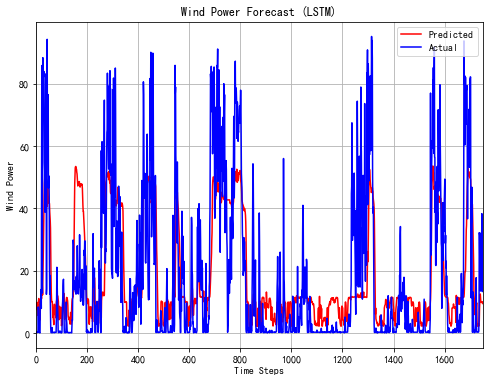

In [11]:
x = np.arange(len(test_df))

plt.figure(figsize=(8, 6))
plt.title('Wind Power Forecast (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Wind Power')
plt.grid(True)

plt.autoscale(axis='x', tight=True)
plt.plot(x, pred_outputs, color='r')
plt.plot(x, actual_values, color='b')
plt.legend(['Predicted', 'Actual'], loc='upper right')
plt.show()

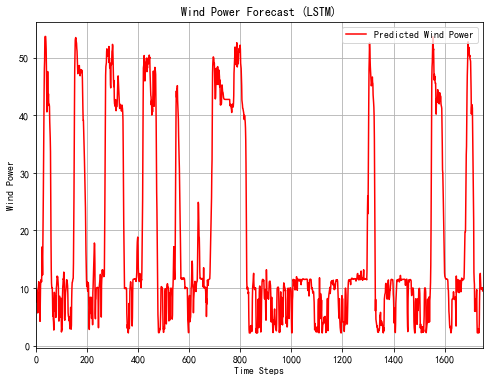

In [12]:
x = np.arange(len(test_df))

plt.figure(figsize=(8, 6))
plt.title('Wind Power Forecast (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Wind Power')
plt.grid(True)

plt.autoscale(axis='x', tight=True)
plt.plot(x, pred_outputs, color='r')
plt.legend(['Predicted Wind Power'], loc='upper right')
plt.show()

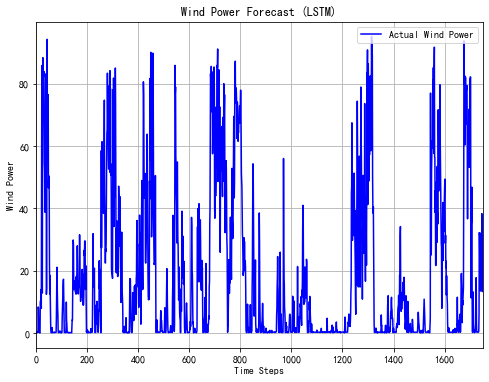

In [13]:
x = np.arange(len(test_df))

plt.figure(figsize=(8, 6))
plt.title('Wind Power Forecast (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Wind Power')
plt.grid(True)

plt.autoscale(axis='x', tight=True)
plt.plot(x, actual_values, color='b')
plt.legend(['Actual Wind Power'], loc='upper right')
plt.show()

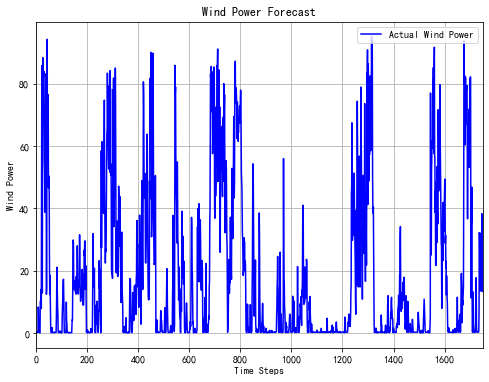

In [14]:
x = np.arange(len(test_df))

plt.figure(figsize=(8, 6))
plt.title('Wind Power Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Wind Power')
plt.grid(True)

plt.autoscale(axis='x', tight=True)
plt.plot(x, actual_values, color='b')
plt.legend(['Actual Wind Power'], loc='upper right')
plt.show()